In [1]:
library(lme4)
library(afex)
library(emmeans)
library(dplyr)
library(ggplot2)
library(svglite)
library(lmtest)
library(tidyr)
library(MCMCglmm)
library(reshape)
library(gridExtra)
library(cowplot)
library(svglite)
library(data.table)

Loading required package: Matrix

************
Welcome to afex. For support visit: http://afex.singmann.science/

- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'S', 'KR', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- Get and set global package options with: afex_options()
- Set sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************


Attaching package: ‘afex’


The following object is masked from ‘package:lme4’:

    lmer



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘tidyr’


The following objects 

In [3]:
ITI <- read.csv('/home/bagotlab/eshaan.i/PRL/FP_PRL_Nov_2021/CLEAN/Data/PRL_ZScore_ITI.csv')
ITI = subset(ITI,ID!=223)
ITI$time_idx <- as.factor(as.numeric(as.factor(ITI$time)))
ITI<-ITI[,c('index','time_idx','time','ID','rewards','lp','LeftLeverProb','Day','rt','PFC','vHIP')]
ITI$sex <- as.factor(ifelse(ITI$ID > 212,"Female", "Male"))
ITI$Day <- as.numeric(as.factor(ITI$Day))

ITI = subset(ITI, lp > 0)
ITI$time_idx <- as.factor(as.numeric(as.factor(ITI$time)))
ITI<- ITI %>% group_by(ID,Day) %>% mutate(Previous.Reward = lag(rewards,n=240))
ITI<- ITI %>% group_by(ID,Day) %>% mutate(Next.Reward = lead(rewards,n=240))
#created lagged dataframe where t2 is now t1
ITI2<-ITI[!is.na(ITI$Previous.Reward),]
ITI<-ITI %>% group_by(ID,Day) %>% mutate(DualTrialTime_Idx = rep_len(1:480, length.out=n()),DualTrial_Idx=rep(1:ceiling(n()/480), each=480, length.out=n()))
ITI2<-ITI2 %>% group_by(ID,Day) %>% mutate(DualTrialTime_Idx = rep_len(1:480, length.out=n()),DualTrial_Idx=rep(1:ceiling(n()/480), each=480, length.out=n()))

ITI = ITI %>% group_by(ID,Day,DualTrial_Idx) %>% mutate(last = DualTrialTime_Idx[[length(DualTrialTime_Idx)]])
ITI2 = ITI2 %>% group_by(ID,Day,DualTrial_Idx) %>% mutate(last = DualTrialTime_Idx[[length(DualTrialTime_Idx)]])

#remove orphan trials
ITI = subset(ITI, last==480)
ITI2 = subset(ITI2, last==480)

ITI$DF <- 0
ITI2$DF <- 1

ITI = rbind(ITI,ITI2)
ITI <- ITI %>% mutate(NewIdx = paste(Day,ID,DualTrial_Idx,DF))
ITI$NewIdx = as.numeric(as.factor(ITI$NewIdx))
ITI<-ITI %>% group_by(NewIdx) %>% mutate(CompoundReward = as.factor(paste(rewards[1],Next.Reward[1])), R1 = as.factor(rewards[1]), R2=as.factor(Next.Reward[1]))

prechoice1<- as.data.frame(ITI[((ITI$DualTrialTime_Idx)>=1)&((ITI$DualTrialTime_Idx)<=40),] %>% group_by(NewIdx)%>%summarize(PFC_Pre1=mean(PFC),vHIP_Pre1=mean(vHIP)))
ITI = merge(ITI,prechoice1,by = 'NewIdx')

#calculate with baseline centered
ITI$PFC = ITI$PFC - ITI$PFC_Pre1
ITI$vHIP = ITI$vHIP - ITI$vHIP_Pre1
prechoice1<- as.data.frame(ITI[((ITI$DualTrialTime_Idx)>=1)&((ITI$DualTrialTime_Idx)<=40),] %>% group_by(NewIdx)%>%summarize(PFC=mean(PFC),vHIP=mean(vHIP),R1=first(R1), R2=first(R2), ID=as.factor(mean(ID)),Day=as.factor(mean(Day)), sex=first(sex)))
enditi1<- as.data.frame(ITI[((ITI$DualTrialTime_Idx)>=200)&((ITI$DualTrialTime_Idx)<=240),] %>% group_by(NewIdx)%>%summarize(PFC=mean(PFC),vHIP=mean(vHIP),R1=first(R1), R2=first(R2), ID=as.factor(mean(ID)),Day=as.factor(mean(Day)), sex=first(sex)))
prechoice2<- as.data.frame(ITI[((ITI$DualTrialTime_Idx)>=241)&((ITI$DualTrialTime_Idx)<=280),] %>% group_by(NewIdx)%>%summarize(PFC=mean(PFC),vHIP=mean(vHIP),R1=first(R1), R2=first(R2), ID=as.factor(mean(ID)),Day=as.factor(mean(Day)), sex=first(sex)))
enditi2<- as.data.frame(ITI[((ITI$DualTrialTime_Idx)>=440)&((ITI$DualTrialTime_Idx)<=480),] %>% group_by(NewIdx)%>%summarize(PFC=mean(PFC),vHIP=mean(vHIP),R1=first(R1), R2=first(R2), ID=as.factor(mean(ID)),Day=as.factor(mean(Day)), sex=first(sex)))

In [5]:
plot_theme <- theme(axis.title=element_text(size=25,color='gray30'),
                    axis.line=element_line(color='gray30'),
                    axis.text.y=element_text(size=20,color='gray30'),
                    axis.text.x=element_text(size=20,color='gray30'),
                    legend.text=element_text(size=20),
                    legend.key.size=unit(2,'mm'),
                    panel.background=element_blank(),
                    panel.grid.major.y = element_blank(),
                    legend.position = 'none',
                    plot.margin = margin(0.5,0.5,0.5,0.5,'cm'),
                    strip.background = element_blank(),
                    strip.text = element_text(size=20,color='gray30')) 

plot_theme_PFC <- list(plot_theme, scale_color_manual(values=c('1.0'="#9E9E9E",'1.1'="#B51D1D",  '0.0'="#444444",'0.1'="#EC407A")),
                        scale_fill_manual(values=c('1.0'="#9E9E9E",'1.1'="#B51D1D",  '0.0'="#444444",'0.1'="#EC407A")),
                        scale_shape_manual(values=c('Male'=16,'Female'=17)))
plot_theme_vHIP <- list(plot_theme, scale_color_manual(values=c('1.0'="#9E9E9E" ,'1.1'="#F27E19", '0.0'="#444444",'0.1'="#FFC107")), 
                        scale_fill_manual(values=c('1.0'="#9E9E9E" ,'1.1'="#F27E19", '0.0'="#444444",'0.1'="#FFC107")),
                        scale_shape_manual(values=c('Male'=16,'Female'=17)))

In [2]:
#Plot mPFC-NAc traces

PFC1Back = NULL
for (tm in 1:480){
myModel=lmer(PFC ~ R1*R2 +(1|ID)+(1|Day),data=subset(ITI, (DualTrialTime_Idx==tm)))
current_time = (tm/20)-2
PFC1Back= rbind(PFC1Back,cbind(time=current_time,as.data.frame(emmeans(myModel, ~ R1*R2))))
}

fig1<-ggplot(data = PFC1Back)+
  geom_line(aes(time,emmean,group=interaction(R1,R2), colour=interaction(R1,R2)))+
  geom_ribbon(aes(x=time,y = emmean, ymin = emmean - SE, ymax = emmean + SE, fill = interaction(R1,R2)), alpha = .2)+
  xlab('Time from LP')+
  ylab('mPFC Activity')+
  geom_vline(xintercept=c(0,10,12,22), linetype="dotted", size = 1)+
  plot_theme_PFC

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 29197' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 29197)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 29197' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 29197)' or larger];
but be warned that this may result in large computation time and memory use.



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: PFC ~ R1 * R2 + (1 | Day) + (1 | ID)
   Data: enditi1

REML criterion at convergence: 40561.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.0014 -0.4166 -0.0002  0.4278 17.3010 

Random effects:
 Groups   Name        Variance  Std.Dev.
 ID       (Intercept) 2.604e-04 0.016138
 Day      (Intercept) 3.772e-05 0.006141
 Residual             2.345e-01 0.484225
Number of obs: 29197, groups:  ID, 21; Day, 6

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  7.440e-02  7.146e-03  3.964e+01  10.411 6.65e-13 ***
R11         -2.151e-01  8.376e-03  2.774e+04 -25.677  < 2e-16 ***
R20          4.195e-03  7.790e-03  2.612e+04   0.539     0.59    
R11:R20     -1.044e-02  1.141e-02  2.919e+04  -0.915     0.36    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr) R11    R20   
R11     -

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



,contrast,R2,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R10 - R11,1,0.2150573,0.008375588,Inf,25.67668,0
2,R10 - R11,0,0.2254969,0.007789301,Inf,28.94956,0
,contrast,R1,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R21 - R20,0,-0.004195302,0.007790330,Inf,-0.5385269,0.8320749
2,R21 - R20,1,0.006244301,0.008374825,Inf,0.7456038,0.7039626


`summarise()` has grouped output by 'ID', 'R1', 'R2'. You can override using
the `.groups` argument.
Warning message:
“Removed 4 rows containing missing values (geom_point).”


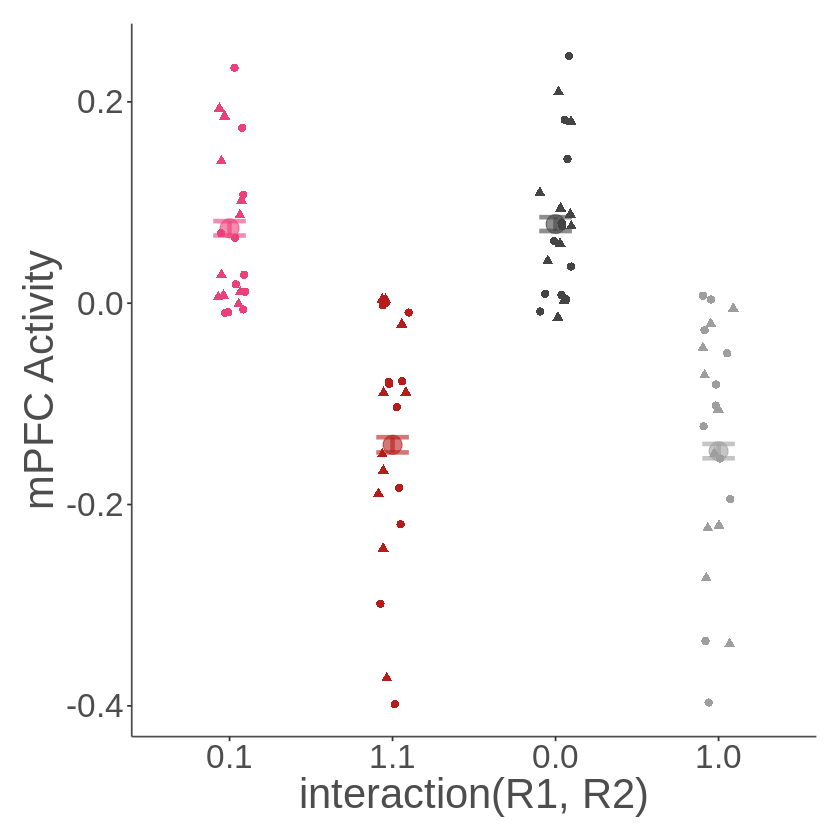

In [6]:
#Quantify mPFC-NAc on t-1

PFC_rewards_enditi <- lmer(PFC~R1*R2+(1|Day)+(1|ID), REML=TRUE ,data = enditi1)
PFC_rewards_enditi_means <- emmeans(PFC_rewards_enditi, ~ R1*R2)

summary(PFC_rewards_enditi)

dtf <- PFC_rewards_enditi_means
simp <- pairs(dtf, simple = "each")
test(simp, by = NULL)
Bulk <- enditi1 %>% group_by(ID, R1,R2,sex) %>% summarise(PFC=mean(PFC, na.rm = TRUE))
dtf<- data.frame(dtf)
ggplot(dtf) +
  geom_point( aes(x=interaction(R1,R2), y=emmean, color=interaction(R1,R2)), stat="identity", size = 5, alpha=0.6) +
  geom_errorbar( aes(x=interaction(R1,R2), ymin=emmean-SE, ymax=emmean+SE,color=interaction(R1,R2)), width=0.2, alpha=0.6, size=1.3) +
  geom_jitter(data=Bulk, aes(x = interaction(R1,R2), y = PFC, color = interaction(R1,R2), shape=sex), size = 2, width = 0.1) +
  ylab('mPFC Activity')+
  plot_theme_PFC

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 29197' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 29197)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 29197' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 29197)' or larger];
but be warned that this may result in large computation time and memory use.



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: PFC ~ R1 * R2 + (1 | Day) + (1 | ID)
   Data: enditi2

REML criterion at convergence: 44896.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-12.2966  -0.4058   0.0096   0.4120  16.5950 

Random effects:
 Groups   Name        Variance  Std.Dev.
 ID       (Intercept) 2.512e-04 0.015849
 Day      (Intercept) 9.562e-05 0.009778
 Residual             2.720e-01 0.521548
Number of obs: 29197, groups:  ID, 21; Day, 6

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept) -1.324e-01  8.093e-03  2.698e+01 -16.364 1.56e-15 ***
R11         -1.742e-02  9.025e-03  2.854e+04  -1.931   0.0535 .  
R20          2.393e-01  8.395e-03  2.731e+04  28.510  < 2e-16 ***
R11:R20     -5.977e-02  1.229e-02  2.919e+04  -4.864 1.15e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr) R11    R20   

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



,contrast,R2,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R10 - R11,1,0.01742547,0.009025053,Inf,1.930788,0.1041552
2,R10 - R11,0,0.07719234,0.008393637,Inf,9.196531,0.0000000
,contrast,R1,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R21 - R20,0,-0.2393310,0.008394703,Inf,-28.50977,0
2,R21 - R20,1,-0.1795642,0.009024165,Inf,-19.89815,0


`summarise()` has grouped output by 'ID', 'R1', 'R2'. You can override using
the `.groups` argument.
Warning message:
“Removed 4 rows containing missing values (geom_point).”


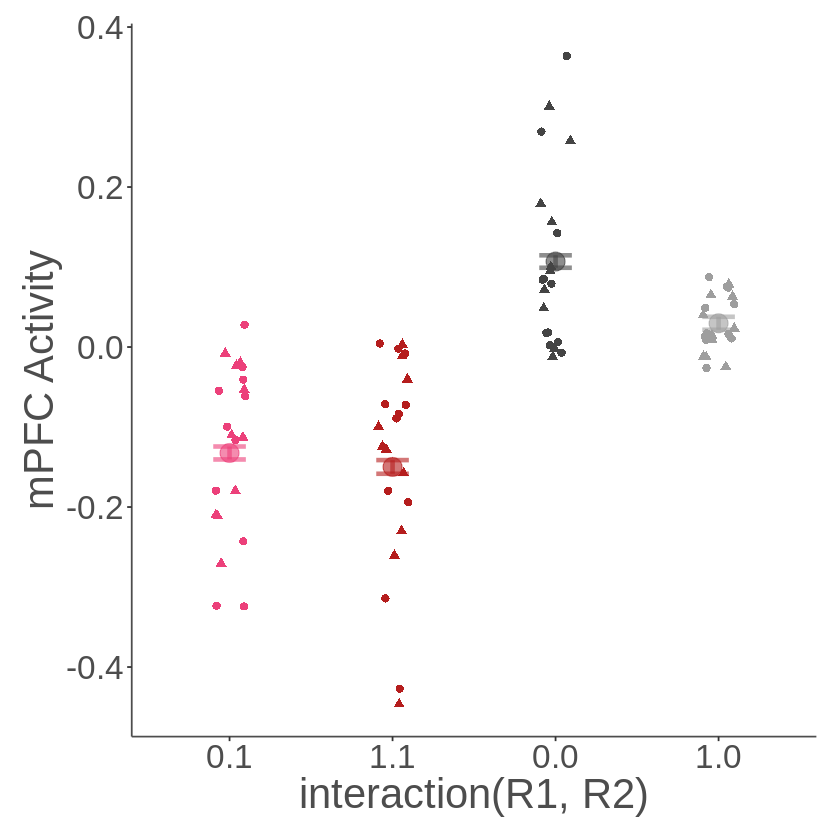

In [7]:
#Quantify mPFC-NAc on t0

PFC_rewards_enditi <- lmer(PFC~R1*R2+(1|Day)+(1|ID), REML=TRUE ,data = enditi2)
PFC_rewards_enditi_means <- emmeans(PFC_rewards_enditi, ~ R1*R2)
summary(PFC_rewards_enditi)
dtf <- PFC_rewards_enditi_means
simp <- pairs(dtf, simple = "each")
test(simp, by = NULL)
Bulk <- enditi2 %>% group_by(ID, R1,R2,sex) %>% summarise(PFC=mean(PFC, na.rm = TRUE))
dtf<- data.frame(dtf)
ggplot(dtf) +
  geom_point( aes(x=interaction(R1,R2), y=emmean, color=interaction(R1,R2)), stat="identity", size = 5, alpha=0.6) +
  geom_errorbar( aes(x=interaction(R1,R2), ymin=emmean-SE, ymax=emmean+SE,color=interaction(R1,R2)), width=0.2, alpha=0.6, size=1.3) +
  geom_jitter(data=Bulk, aes(x = interaction(R1,R2), y = PFC, color = interaction(R1,R2), shape=sex), size = 2, width = 0.1) +
  ylab('mPFC Activity')+
  plot_theme_PFC

In [ ]:
#Plot vHIP-NAc traces

vHIP1Back = NULL
for (tm in 1:480){
myModel=lmer(vHIP ~ R1*R2 +(1|ID)+(1|Day),data=subset(ITI, (DualTrialTime_Idx==tm)))
current_time = (tm/20)-2
vHIP1Back= rbind(vHIP1Back,cbind(time=current_time,as.data.frame(emmeans(myModel, ~ R1*R2))))
}

ggplot(data = vHIP1Back)+
  geom_line(aes(time,emmean,group=interaction(R1,R2), colour=interaction(R1,R2)))+
  geom_ribbon(aes(x=time,y = emmean, ymin = emmean - SE, ymax = emmean + SE, fill = interaction(R1,R2)), alpha = .2)+
  xlab('Time from LP')+
  ylab('vHip Activity')+
  geom_vline(xintercept=c(0,10,12,22), linetype="dotted", size = 1)+
  plot_theme_vHIP

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 30660' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 30660)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 30660' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 30660)' or larger];
but be warned that this may result in large computation time and memory use.



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: vHIP ~ R1 * R2 + (1 | Day) + (1 | ID)
   Data: enditi1

REML criterion at convergence: 39677.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-10.2801  -0.4595   0.0059   0.4755  16.0334 

Random effects:
 Groups   Name        Variance  Std.Dev.
 ID       (Intercept) 0.0001984 0.01409 
 Day      (Intercept) 0.0002460 0.01568 
 Residual             0.2131731 0.46171 
Number of obs: 30660, groups:  ID, 22; Day, 6

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  2.025e-02  8.834e-03  1.270e+01   2.292   0.0396 *  
R11         -9.115e-02  7.793e-03  3.053e+04 -11.696   <2e-16 ***
R20          1.565e-02  7.264e-03  2.972e+04   2.154   0.0312 *  
R11:R20     -1.733e-02  1.061e-02  3.065e+04  -1.633   0.1025    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr) R11    R20  

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



,contrast,R2,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R10 - R11,1,0.09114994,0.007793110,Inf,11.69622,0
2,R10 - R11,0,0.10847931,0.007262353,Inf,14.93721,0
,contrast,R1,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R21 - R20,0,-0.015645941,0.007263513,Inf,-2.154046,0.0614974
2,R21 - R20,1,0.001683437,0.007792138,Inf,0.216043,0.9707434


`summarise()` has grouped output by 'ID', 'R1', 'R2'. You can override using
the `.groups` argument.
Warning message:
“Removed 4 rows containing missing values (geom_point).”


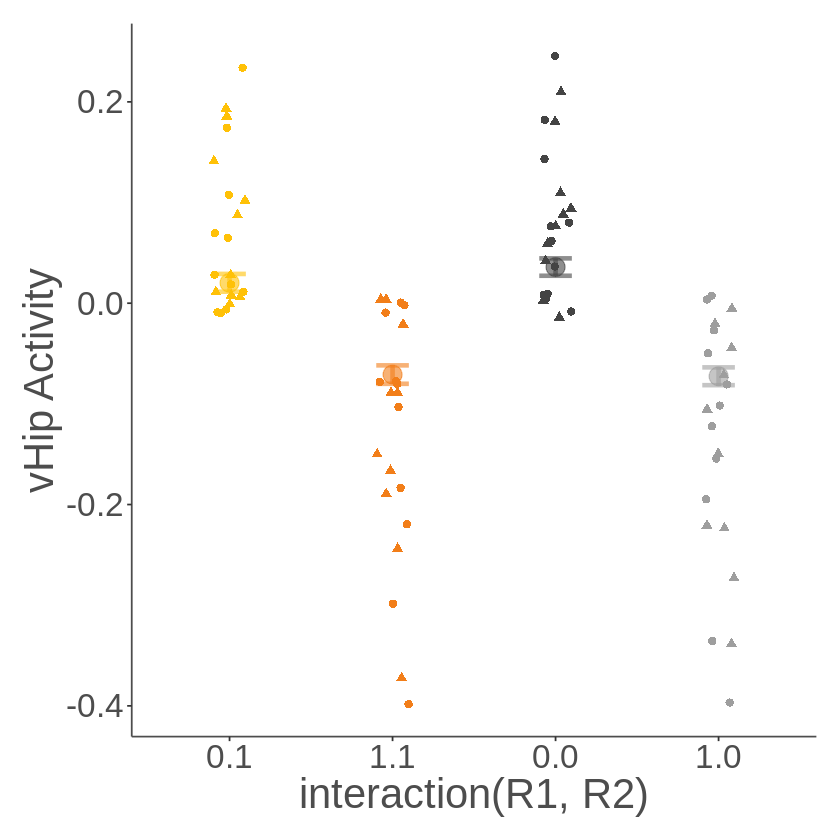

In [11]:
#Quantify vHIP-NAc on t-1

vHIP_rewards_enditi <- lmer(vHIP~R1*R2+(1|Day)+(1|ID), REML=TRUE ,data = enditi1)
vHIP_rewards_enditi_means <- emmeans(vHIP_rewards_enditi, ~ R1*R2)
summary(vHIP_rewards_enditi)
dtf <- vHIP_rewards_enditi_means
simp <- pairs(dtf, simple = "each")
test(simp, by = NULL)
Bulk <- enditi1 %>% group_by(ID, R1,R2,sex) %>% summarise(PFC=mean(PFC, na.rm = TRUE))
dtf<- data.frame(dtf)
ggplot(dtf) +
  geom_point( aes(x=interaction(R1,R2), y=emmean, color=interaction(R1,R2)), stat="identity", size = 5, alpha=0.6) +
  geom_errorbar( aes(x=interaction(R1,R2), ymin=emmean-SE, ymax=emmean+SE,color=interaction(R1,R2)), width=0.2, alpha=0.6, size=1.3) +
  geom_jitter(data=Bulk, aes(x = interaction(R1,R2), y = PFC, color = interaction(R1,R2), shape=sex), size = 2, width = 0.1) +
  ylab('vHip Activity')+
  plot_theme_vHIP

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 30660' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 30660)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 30660' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 30660)' or larger];
but be warned that this may result in large computation time and memory use.



,R1,R2,emmean,SE,df,asymp.LCL,asymp.UCL
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,-0.06763603,0.009789905,Inf,-0.08682390,-0.0484481717
2,1,1,-0.07960627,0.010124027,Inf,-0.09944900,-0.0597635436
3,0,0,0.06951111,0.009590706,Inf,0.05071367,0.0883085476
4,1,0,-0.01990735,0.009789143,Inf,-0.03909372,-0.0007209832


Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



,contrast,R2,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R10 - R11,1,0.01742547,0.009025053,Inf,1.930788,0.1041552
2,R10 - R11,0,0.07719234,0.008393637,Inf,9.196531,0.0000000
,contrast,R1,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R21 - R20,0,-0.2393310,0.008394703,Inf,-28.50977,0
2,R21 - R20,1,-0.1795642,0.009024165,Inf,-19.89815,0


`summarise()` has grouped output by 'ID', 'R1', 'R2'. You can override using
the `.groups` argument.
Warning message:
“Removed 4 rows containing missing values (geom_point).”


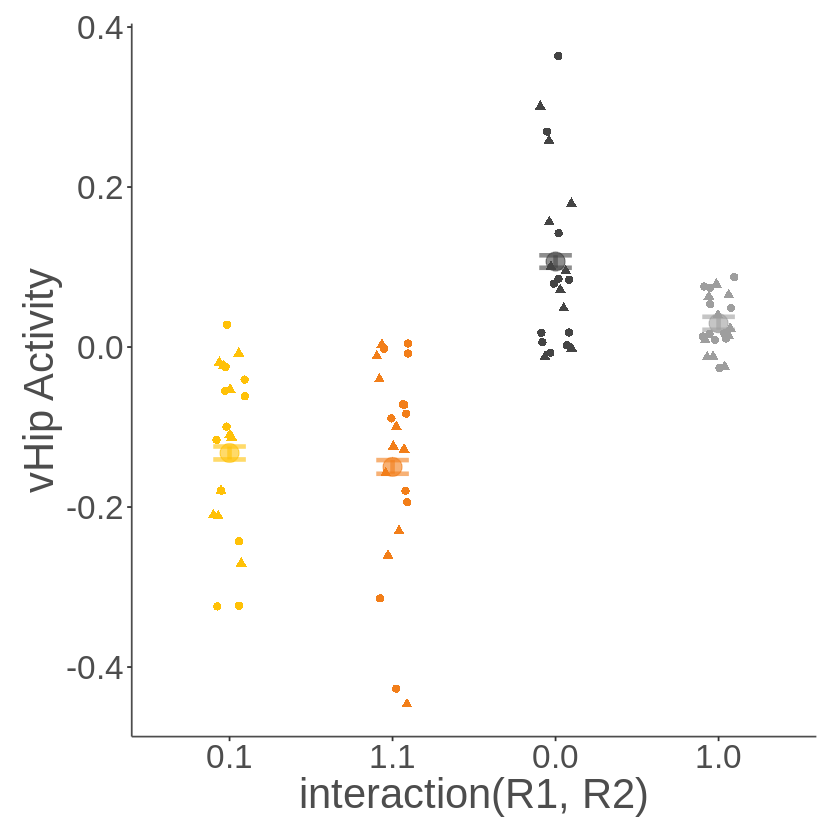

In [12]:
#Quantify vHIP-NAc on t0

vHIP_rewards_enditi <- lmer(vHIP~R1*R2+(1|Day)+(1|ID), REML=TRUE ,data = enditi2)
vHIP_rewards_enditi_means <- emmeans(vHIP_rewards_enditi, ~ R1*R2)
summary(vHIP_rewards_enditi_means)
dtf <- PFC_rewards_enditi_means
simp <- pairs(dtf, simple = "each")
test(simp, by = NULL)
Bulk <- enditi2 %>% group_by(ID, R1,R2,sex) %>% summarise(PFC=mean(PFC, na.rm = TRUE))
dtf<- data.frame(dtf)
ggplot(dtf) +
  geom_point( aes(x=interaction(R1,R2), y=emmean, color=interaction(R1,R2)), stat="identity", size = 5, alpha=0.6) +
  geom_errorbar( aes(x=interaction(R1,R2), ymin=emmean-SE, ymax=emmean+SE,color=interaction(R1,R2)), width=0.2, alpha=0.6, size=1.3) +
  geom_jitter(data=Bulk, aes(x = interaction(R1,R2), y = PFC, color = interaction(R1,R2), shape=sex), size = 2, width = 0.1) +
  ylab('vHip Activity')+
  plot_theme_vHIP